# Training

This notebook loads the ETL data and trains the LSTM. 

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os.path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
x_train = xr.open_dataarray('./etl_data/x_train.nc')
x_val = xr.open_dataarray('./etl_data/x_val.nc')
y_train = xr.open_dataarray('./etl_data/y_train.nc')
y_val = xr.open_dataarray('./etl_data/y_val.nc')
dims = dict(zip(x_train.dims, x_train.shape))
dims

{'samples': 464187, 'lookback': 90, 'features': 6}

In [10]:
class LossHistory(keras.callbacks.Callback):
    '''Helper class to record the loss history'''
    
    def __init__(self, frequency=100):
        self.frequency = frequency
        self.batch_counter = 0
        self.losses = []
    
    def on_batch_end(self, batch, logs={}):
        if batch % self.frequency == 0:
            self.batch_counter += self.frequency
            self.losses.append([logs.get('loss')])
        
fresh_model = True
            
if fresh_model:
    input_shape = (dims['lookback'], dims['features'])

    # design network
    model = Sequential()
    model.add(LSTM(20, input_shape=input_shape, use_bias=True))
    model.add(Dense(1))
    model.compile(loss='3', optimizer='adam')
else:
    from keras.models import load_model
    model = load_model('model.h5')
    
model.summary()
    
history = LossHistory()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model
with tf.device('/GPU:0'):
    model.fit(x_train.values, y_train.values,
              validation_data=(x_val.values, y_val.values),
              batch_size=3650, epochs=3000,
              shuffle=True, callbacks=[history])

Train on 464187 samples, validate on 55000 samples
Epoch 1/1000
464187/464187 [==============================] - 2s 5us/sample - loss: 0.0072 - val_loss: 0.0078
Epoch 2/1000
464187/464187 [==============================] - 2s 5us/sample - loss: 0.0072 - val_loss: 0.0078
Epoch 3/1000
464187/464187 [==============================] - 2s 5us/sample - loss: 0.0072 - val_loss: 0.0080
Epoch 4/1000
464187/464187 [==============================] - 2s 5us/sample - loss: 0.0072 - val_loss: 0.0078
Epoch 5/1000
464187/464187 [==============================] - 2s 5us/sample - loss: 0.0072 - val_loss: 0.0078
Epoch 6/1000
464187/464187 [==============================] - 2s 5us/sample - loss: 0.0072 - val_loss: 0.0079
Epoch 7/1000
464187/464187 [==============================] - 2s 5us/sample - loss: 0.0072 - val_loss: 0.0078
Epoch 8/1000
464187/464187 [==============================] - 2s 5us/sample - loss: 0.0072 - val_loss: 0.0078
Epoch 9/1000
464187/464187 [==============================] - 2s 5us/

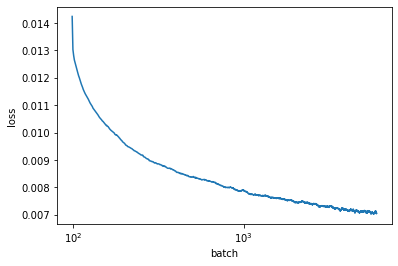

In [64]:
loss = np.array(history.losses).squeeze()
ds_hist = xr.Dataset({'loss': ('batch', loss)}).rolling(batch=100).mean()#.isel(batch=slice(-2000, -1))
ds_hist.loss.plot()
plt.xscale('symlog')


In [40]:
model.save('model.h5')